# Teorema Central do Limite

por Danilo J. S. Bellini

O objetivo dos códigos neste notebook é possibilitar a ilustração/aplicação do conteúdo matemático/estatístico, de forma que o leitor não precisa se prender aos mesmos para a compreensão do conteúdo exposto.

O Teorema do Limite Central é um resultado fundamental em teoria de probabilidades e estatística. Resumidamente, o teorema diz que a média e a soma de variáveis aleatórias independentes identicamente distribuídas (*i.i.d.*) convergem em distribuição para a distribuição normal, e que isso (até certo ponto) independe da distribuição original.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sympy import Symbol, I, exp
from sympy.stats import Normal, E
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
t = Symbol("t", positive=True)
mu = Symbol("mu", real=True)
sigma = Symbol("sigma", positive=True)

## Introdução: RPG - Role Playing Game com dados!

![](my_die.jpg)

Estamos jogando RPG! Os resultados das ações do nosso personagem dependem do resultado de lançamentos de dados como $d4$, $d10$ e $d20$, em que o número representa a quantidade de lados do dado. A notação $KdN$ representa a soma de $K$ lançamentos do dado $dN$.

Durante uma batalha, você deve lançar um dado de $20$ lados ($1d20$). Nas condições dessa batalha, se seu resultado for maior ou igual a $16$, você pode vencer, do contrário, seu personagem poderá será derrotado.

Diante dessa situação, o mestre do RPG sugere uma alternativa: lançar $2$ vezes o $d10$ e utilizar a soma como se esta fosse um lançamento do $d20$. Ou mesmo lançar $5$ vezes o $d4$. Admitindo que os dados não sejam viciados, qual abordagem maximiza a probabilidade de termos um resultado maior ou igual a $16$, com $1d20$, $2d10$ ou $5d4$?

Para um dado convencional de $10$ lados não-viciado, temos a seguinte distribuição de probabilidades:

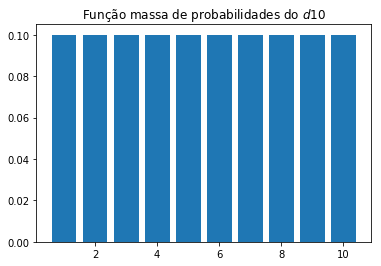

In [4]:
sides = range(1, 11)
plt.bar(sides, .1)
plt.title("Função massa de probabilidades do $d10$");

Em um experimento, o histograma dificilmente será idêntico a essa distribuição. Por exemplo, simulando $2000$ lançamentos desse dado, temos:

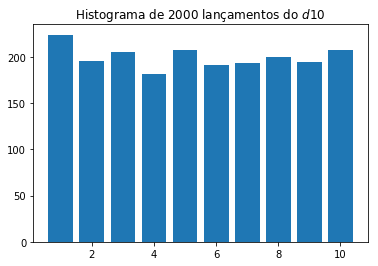

In [5]:
events10 = np.random.randint(1, 11, size=2000)
plt.bar(sides, np.bincount(events10)[1:])
plt.title("Histograma de $2000$ lançamentos do $d10$");

Se a ideia é utilizar $2d10$ ao invés de $1d20$, podemos pegar pares adjacentes desses lançamentos e utilizar as somas como nossos *compounds*. O resultado é:

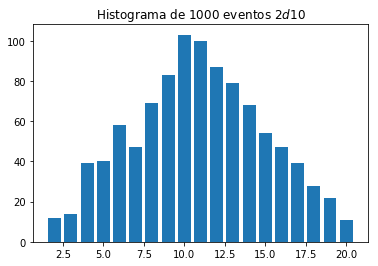

In [6]:
plt.bar(range(2, 21), np.bincount(events10.reshape(-1, 2).sum(axis=1))[2:])
plt.title("Histograma de $1000$ eventos $2d10$");

Embora o espaço amostral da composição $2d10$ seja menor que o espaço amostral do evento $1d20$ devido à impossibilidade de se obter o valor $1$ com o resultado da soma de $2$ lançamentos, a distribuição resultante dos $2$ lançamentos é triangular, o que torna o eventos como o $20$ improvável.

Com $5$ lançamentos de dados de $4$ lados, obteríamos:

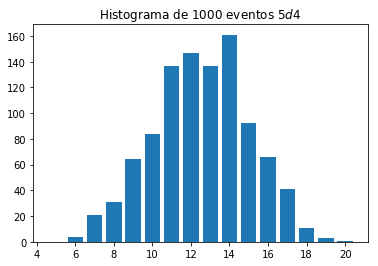

In [7]:
events4 = np.random.randint(1, 5, size=5000)
plt.bar(range(5, 21), np.bincount(events4.reshape(-1, 5).sum(axis=1))[5:])
plt.title("Histograma de $1000$ eventos $5d4$");

Esse novo histograma já não é mais um triângulo.

Utilizando as frequências relativas empiricamente coletadas como estimativa da probabilidade de obtermos um número maior ou igual a 16, teríamos:

In [8]:
events20 = np.random.randint(1, 21, size=1000)

In [9]:
freqs_dframe = pd.DataFrame({
    "$1d20$": [(events20 >= 16).mean()],
    "$2d10$": [(events10.reshape(-1, 2).sum(axis=1) >= 16).mean()],
    "$5d4$": [(events4.reshape(-1, 5).sum(axis=1) >= 16).mean()],
}, index=["Frequências relativas em que $X \ge 16$"])
freqs_dframe

,$1d20$,$2d10$,$5d4$
Frequências relativas em que $X \ge 16$,0.263,0.147,0.122


Aparentemente não vale a pena trocar o $1d20$ pelas outras alternativas, embora seja impossível a falha crítica (soma $1$) nos outros casos e o menor resultado possível para o $5d4$ seja $5$, diminuindo o espaço amostral apenas na faixa de valores que resultariam numa derrota no jogo de RPG.

É possível calcular os valores exatos dessas probabilidades:

In [10]:
def brute_force_dice_sum_threshold_probability(quantity, sides, threshold=16, saturation=None):
    return (sum(np.clip(np.arange(sides ** k)
                          .repeat(sides ** (quantity - k)) % sides,
                        0, (saturation or sides) - 1)
                for k in range(1, quantity + 1)) >= threshold - quantity
           ).mean()

In [11]:
freqs_dframe.loc["$P(X \ge 16)$"] = {
    "$1d20$": brute_force_dice_sum_threshold_probability(1, 20),
    "$2d10$": brute_force_dice_sum_threshold_probability(2, 10),
    "$5d4$": brute_force_dice_sum_threshold_probability(5, 4),
}
freqs_dframe

,$1d20$,$2d10$,$5d4$
Frequências relativas em que $X \ge 16$,0.263,0.147,0.122000
$P(X \ge 16)$,0.250,0.150,0.118164


## Dado de 6 lados

Se o dado tivesse $6$ lados, estas seriam as funções massa de probabilidade para a soma dos resultados de $n$ lançamentos (Imagens obtidas da Wikipedia):

[![](Probability density function of the sum of two dice.svg)](https://en.wikipedia.org/wiki/File:Dice_Distribution_%28bar%29.svg)

[![](Comparison of probability density functions for the sum of n dice to illustrate the central limit theorem.svg)](https://en.wikipedia.org/wiki/File:Dice_sum_central_limit_theorem.svg)

A última imagem mostra as distribuições centralizadas e com um fator de escala ajustado de forma a ilustrar que essas somas aparentemente convergem para uma mesma distribuição.

## Skewness (assimetria / obliquidade)

Depois de mostrar esses resultados para o mestre do RPG, já quase acusando ele de querer ludibriar os jogadores com um procedimento que diminui as chances de vitória, o próprio mestre fornece uma alternativa para se redimir: lançar $5d6$, mas "saturar" os valores dos dados $d6$ para que nunca ultrapassem $4$ individualmente. Dessa vez temos uma distribuição assimétrica!

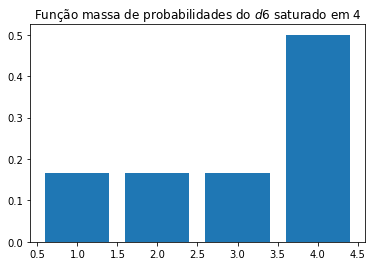

In [12]:
plt.bar([1, 2, 3, 4], np.array([1, 1, 1, 3]) / 6)
plt.title("Função massa de probabilidades do $d6$ saturado em $4$");

Efetuando o experimento $1000$ vezes, como realizado anteriormente, obtemos:

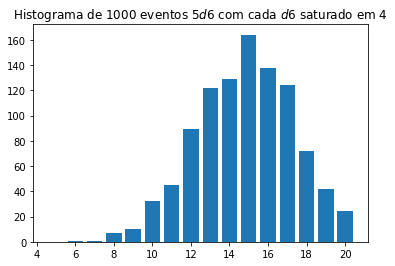

In [13]:
events6 = np.random.randint(1, 7, size=5000)
events6_clip4 = np.clip(events6, None, 4)
plt.bar(range(5, 21), np.bincount(events6_clip4.reshape(-1, 5).sum(axis=1))[5:])
plt.title("Histograma de $1000$ eventos $5d6$ com cada $d6$ saturado em $4$");

In [14]:
freqs_dframe["$5d6$ saturado"] = [
    (events6_clip4.reshape(-1, 5).sum(axis=1) >= 16).mean(),
    brute_force_dice_sum_threshold_probability(5, 6, saturation=4),
]
freqs_dframe

,$1d20$,$2d10$,$5d4$,$5d6$ saturado
Frequências relativas em que $X \ge 16$,0.263,0.147,0.122000,0.400000
$P(X \ge 16)$,0.250,0.150,0.118164,0.444059


Dessa vez vale a pena aceitar a proposta do mestre! Porém, o que aconteceria com a distribuição se lançássemos $25d6$ com essa saturação em $4$ para cada dado?

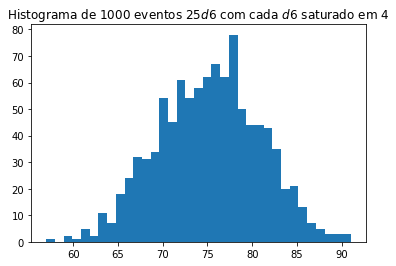

In [15]:
events6_more = np.random.randint(1, 7, size=25000)
events25d6_clip4 = np.clip(events6_more, None, 4).reshape(-1, 25).sum(axis=1)
plt.hist(events25d6_clip4, bins=events25d6_clip4.ptp() + 1)
plt.title("Histograma de $1000$ eventos $25d6$ com cada $d6$ saturado em $4$");

O $d6$ saturado é basicamente um $d4$ viciado ($50\%$ das vezes resulta em $4$), porém essa distribuição de $25d6$ saturado está quase simétrica!

Embora a convergência na direção da distribuição normal não seja uniforme (as caudas da distribuição levam mais iterações que a região central), esse é um resultado prático previsto por aqueles que conhecem o Teorema do Limite Central: a distribuição da soma de $n$ variáveis aleatórias *i.i.d.* converge em distribuição para a normal com o aumento do $n$, mesmo que a distribuição original seja assimétrica.

Para uma ilustração interativa, veja: http://onlinestatbook.com/stat_sim/sampling_dist/index.html

## Distribuição normal

A distribuição normal/gaussiana $\mathcal{N}(\mu, \sigma^2)$ é dada pela equação:

$$
\displaystyle f(x | \mu, \sigma^2) =
\frac{\displaystyle 1}
     {\displaystyle \sqrt{2 \pi \sigma^2}}
\cdot
e^{\displaystyle - \frac{\textstyle(x - \mu)^2}
                        {\textstyle2 \sigma^2}}
$$


Essa é a função densidade de probabilidade para média $\mu$ e variância $\sigma^2$.

A distribuição normal padrão é aquela com média zero e variância unitária, $\mathcal{N}(0, 1)$:

$$
\displaystyle \phi(x) =
\frac{\displaystyle 1}
     {\displaystyle \sqrt{2 \pi}}
\cdot
e^{\displaystyle - x^2 / 2}
$$

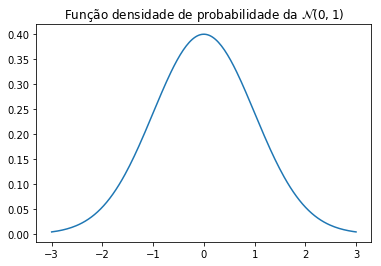

In [16]:
xs = np.linspace(-3, 3, 200)
plt.plot(xs, stats.norm.pdf(xs))
plt.title("Função densidade de probabilidade da $\mathcal{N}(0, 1)$");

Essa distribuição possui diversas propriedades importantes, por exemplo a soma de duas variáveis aleatórias com distribuição normal resulta em uma variável aleatória com distribuição normal.

## Erro da média

Se $\bar{X}$ é a média de uma amostra, a distribuição da variáveis aleatórias $\bar{X}$ é diferente da distribuição dos $X$ originais. As médias se mantém:

$$\require{cancel}
E[\bar{X}]
= E \left[ \frac{1}{n} \sum_{i=1}^{n} X_i \right]
= \frac{1}{n} \sum_{i=1}^{n} E[X_i]
= \frac{1}{\cancel{n}} \cancel{ \left[ \sum_{i=1}^{n} 1 \right] } E[X]
= E[X]
$$

Por outro lado, a variância da distribuição das médias não é igual à variância da distribuição original:

$$\require{cancel}
\operatorname{var} \bar{X}
= \operatorname{var} \left[ \frac{1}{n} \sum_{i=1}^{n} X_i \right]
= \frac{1}{n^2} \sum_{i=1}^{n} \operatorname{var} X_i
= \frac{1}{n^\cancel{2}} \cancel{ \left[ \sum_{i=1}^{n} 1 \right] } \operatorname{var} X
= \frac{\operatorname{var} X}{n}
$$

Isso é importante neste contexto: se o desvio padrão da distribuição original é $\sigma$, o erro padrão da média é $\sigma \left/ \sqrt{n} \right.$.

## Formalização do CLT (Central Limit Theorem)

Há mais de uma forma de provar o teorema do limite central. O que segue é uma prova fundamentada na função característica, utilizando, ao final, o teorema da convergência de Lévy.

A formulação clássica pode ser ilustrada por esta imagem (obtida da Wikipedia), mas vamos adotar uma conversão para evitar os deslocamentos de média e desvio padrão:

[![](IllustrationCentralTheorem.png)](https://en.wikipedia.org/wiki/File:IllustrationCentralTheorem.png)

Seja ${X_i}$ uma sequência de variáveis aleatórias *i.i.d.* com média $E[X_i] = \mu$ e variância $\operatorname{var}(X_i) = \sigma^2 > 0$. A soma dos $n$ primeiros elementos da sequência é:

$$
S_n = \sum_{i=1}^n X_i
$$

Queremos mostrar que:

$$
\bar{X}
\xrightarrow{\mathcal{D}}
\mathcal{N} \left( \mu, \frac{\sigma^2}{n} \right)
$$

Ou,

$$
S_n
\xrightarrow{\mathcal{D}}
\mathcal{N} \left( n \mu, n \sigma^2 \right)
$$

Ou, equivalentemente,

$$
Z_n
=
\frac{\displaystyle \frac{1}{n} \sum_{i=1}^n \left( X_i - \mu \right)}
     {\sigma \left/ \sqrt{n} \right.}
=
\frac{S_n - n \mu}{\sqrt{n \sigma^2}}
\xrightarrow{\mathcal{D}}
\mathcal{N}(0, 1)
$$

Em que o símbolo $\xrightarrow{\mathcal{D}}$ denota que o lado esquerdo converge em distribuição ao lado direito para valores maiores de $n$.

## Função característica

A *função característica* de uma distribuição é o valor esperado da exponencial complexa $e^{i t X}$, consistindo fundamentalmente em uma inversa da transformada de Fourier da função densidade de probabilidade.

$$
cf_X(t) = E[e^{i t X}] = E[exp(i t X)]
$$

No caso da distribuição normal, a função característica é:

In [17]:
X = Normal("X", mu, sigma)
E(exp(I * t * X)).simplify() # Characteristic Function da N(mu, sigma^2)

exp(t*(I*mu - sigma**2*t/2))

Ou:

$$
cf_{\mathcal{N}(\mu, \sigma^2)}(t)
=
\exp \left( i \mu t - \frac{1}{2} \sigma^2 t^2 \right)
$$

Para a $\mathcal{N}(0, 1)$, temos:

$$
cf_{\mathcal{N}(0, 1)}(t)
=
\exp \left( - \frac{t^2}{2} \right)
$$

In [18]:
cf = E(exp(I * t * X.subs({mu: 0, sigma: 1}))).simplify()
cf # Characteristic Function da N(0, 1)

exp(-t**2/2)

## Relação entre funções características

Seja:

$$
Y_i = \frac{X_i - \mu}{\sigma}
$$

Dessa forma, temos $E[Y_i] = 0$, por conta da subtração no numerador, e $\operatorname{var}[Y_i] = 1$, por conta da normalização realizada pelo denominador.

A anteriormente definida $Z_n$ pode então ser escrita como função de $Y_i$:

$$
Z_n
=
\frac{\displaystyle \frac{1}{n} \sum_{i=1}^n \left( X_i - \mu \right)}
     {\sigma \left/ \sqrt{n} \right.}
=
\frac{1}{\sqrt{n}}
\sum_{i=1}^n \frac{X_i - \mu}{\sigma}
=
\frac{1}{\sqrt{n}}
\sum_{i=1}^n Y_i
$$

Calculando a função característica da $Z_n$, obtemos:

$$
\begin{array}{rcl} \displaystyle
cf_{Z_n}(t)
   & \displaystyle = & \displaystyle
E\left[ \exp \left( i t Z_n \right) \right]
\\ & \displaystyle = & \displaystyle
E\left[ \exp \left( \frac{i t}{\sqrt{n}} \sum_{j=1}^n Y_j \right) \right]
\\ & \displaystyle = & \displaystyle
E\left[ \prod_{j=1}^n \exp \left( \frac{i t}{\sqrt{n}} Y_j \right) \right]
\\ & \displaystyle \stackrel{i.i.d.}{=} & \displaystyle
\prod_{j=1}^n E\left[ \exp \left( i \frac{t}{\sqrt{n}} Y_j \right) \right]
\\ & \displaystyle = & \displaystyle
\prod_{j=1}^n cf_{Y_j}\left( \frac{t}{\sqrt{n}} \right)
\\ & \displaystyle = & \displaystyle
\left[ cf_{Y}\left( \frac{t}{\sqrt{n}} \right) \right]^n
\end{array}
$$

## Expansão em série Taylor

A partir da série de Taylor / McLaurin de $e^{x}$, temos:

$$
\sum_{k=0}^\infty \frac{x^k}{k!}
$$

Embora não estejamos utilizando, a função geradora de momentos é o valor esperado dessa última exponencial para $x = t X$, de forma que:

$$
M_X(t)
=
E\left[ e^{t X} \right]
=
E\left[ \sum_{k=0}^\infty \frac{(t X)^k}{k!} \right]
=
\sum_{k=0}^\infty E\left[ \frac{X^k}{k!} t^k \right]
=
\sum_{k=0}^\infty \frac{E[X^k]}{k!} t^k
$$

Na função característica, a exponencial é complexa, nosso expoente é $x = i t X$:

$$
cf_X(t)
=
E\left[ e^{i t X} \right]
=
\sum_{k=0}^\infty \frac{E[X^k]}{k!} t^k i^k
$$

Ou,

$$
cf_X(t)
=
1
+ E(X) t i
- \frac{E(X^2)}{2} t^2
- \frac{E(X^3)}{3!} t^3 i
+ \frac{E(X^4)}{4!} t^4
+ \sum_{k=5}^\infty \frac{E[X^k]}{k!} t^k i^k
$$

Substituindo $X$ por $Y$, e $t$ por $t \left/ \sqrt{n} \right.$,

$$
cf_Y\left( \frac{t}{\sqrt{n}} \right)
=
1
+ \frac{E(Y)}{\sqrt{n}} t i
- \frac{E(Y^2)}{2 n} t^2
- \frac{E(Y^3)}{3! n \sqrt{n}} t^3 i
+ \frac{E(Y^4)}{4! n^2} t^4
+ \sum_{k=5}^\infty \frac{E[Y^k]}{k! \sqrt{n^k}} t^k i^k
$$

Para o caso da $cf_Y(\cdot)$, nós sabemos que $E[Y] = 0$ e que $\require{cancel} \operatorname{var}(Y) = E[Y^2] - \cancelto{0}{E[Y]^2} = 1$, logo:

$$\require{cancel}
cf_Y\left( \frac{t}{\sqrt{n}} \right)
=
E\left[ \exp \left( i \frac{t}{\sqrt{n}} Y \right) \right]
=
1
+ \cancel{0 \frac{t}{\sqrt{n}} i}
- \frac{1}{2} \frac{t^2}{n}
- \frac{E(Y^3)}{3!} \frac{t^3}{n \sqrt{n}} i
+ \frac{E(Y^4)}{4!} \frac{t^4}{n^2}
+ \sum_{k=5}^\infty \frac{E[Y^k]}{k! \sqrt{n^k}} t^k i^k
$$

Deixando fora do somatório somente os termos sobre os quais temos a informação completa,

$$
cf_Y\left( \frac{t}{\sqrt{n}} \right)
=
1 - \frac{t^2}{2 n} + \sum_{k=3}^\infty \frac{E[Y^k]}{k! \sqrt{n^k}} t^k i^k
$$

Esse resultado vale para qualquer variável $Y$ definida como *z-score* de outra distribuição, como fizemos com $X$. Em particular, o polinômio de Taylor de segunda ordem da $\mathcal{N}(0, 1)$ também possui essa configuração (exemplo com $n = 1$):

In [19]:
cf.subs({t: 0}) + t * cf.diff(t).subs({t: 0}) + t ** 2 * cf.diff(t, 2).subs({t: 0}) / 2

-t**2/2 + 1

## Finalizando a prova do teorema

Queremos saber o que acontece com a função característica de $Z_n$ quando $n$ é grande:

$$
\begin{array}{rcl} \displaystyle
\lim_{n \to \infty} cf_{Z_n}(t)
   & \displaystyle = & \displaystyle
\lim_{n \to \infty} \left[ cf_{Y}\left( \frac{t}{\sqrt{n}} \right) \right]^n
\\ & \displaystyle = & \displaystyle
\lim_{n \to \infty} \left[ 1 - \frac{t^2}{2 n} + \sum_{k=3}^\infty \frac{E[Y^k]}{k! \sqrt{n^k}} t^k i^k \right]^n
\end{array}
$$

Ao invés disso, se tentássemos obter o limite do logaritmo natural da função característica de $Z_n$, teríamos:

$$
\begin{array}{rcl} \displaystyle
\lim_{n \to \infty} \ln \left[ cf_{Z_n}(t) \right]
   & \displaystyle = & \displaystyle
\lim_{n \to \infty} \ln \left[ 1 - \frac{t^2}{2 n} + \sum_{k=3}^\infty \frac{E[Y^k]}{k! \sqrt{n^k}} t^k i^k \right]^n
\\ & \displaystyle = & \displaystyle
\lim_{n \to \infty} n \; \ln \left[ 1 - \frac{t^2}{2 n} + \sum_{k=3}^\infty \frac{E[Y^k]}{k! \sqrt{n^k}} t^k i^k \right]
\\ & \displaystyle \stackrel{n = 1 / m}{=} & \displaystyle
\lim_{m \to 0}
  \frac{\displaystyle \ln \left[ 1 - \frac{t^2 m}{2} + \sum_{k=3}^\infty \frac{E[Y^k]}{k!} t^k i^k \sqrt{m^k} \right]}
       {\displaystyle m}
\\ & \displaystyle \stackrel{L'Hôpital}{=} & \displaystyle
\lim_{m \to 0}
  \frac{\displaystyle - \frac{t^2}{2} + \sum_{k=3}^\infty \frac{k}{2} \frac{E[Y^k]}{k!} t^k i^k m^{k/2 - 1}}
       {\displaystyle 1 - \frac{t^2 m}{2} + \sum_{k=3}^\infty \frac{E[Y^k]}{k!} t^k i^k \sqrt{m^k}}
\\ & \displaystyle = & \displaystyle
\lim_{m \to 0} \frac{- \frac{t^2}{2}
                     + \cancel{\frac{3}{2} \frac{E[Y^3]}{3!} t^3 i^3 \sqrt{m}}
                     + \cancel{\frac{4}{2} \frac{E[Y^4]}{4!} t^4 i^4 m}
                     + \cancel{\frac{5}{2} \frac{E[Y^5]}{5!} t^5 i^5 m \sqrt{m}}
                     + \cdots
               }{1 - \cancel{\frac{t^2 m}{2}}
                   + \cancel{\frac{E[Y^3]}{3!} t^3 i^3 m \sqrt{m}}
                   + \cancel{\frac{E[Y^4]}{4!} t^4 i^4 m^2}
                   + \cancel{\frac{E[Y^5]}{5!} t^5 i^5 m^2 \sqrt{m}}
                   + \cdots
               }
\\ & \displaystyle = & \displaystyle
- \frac{t^2}{2}
\end{array}
$$

Onde usamos a regra de L'Hôpital pelo fato de que tanto o numerador como o denominador do limite convergiam para zero.

Logo,

$$
\lim_{n \to \infty} cf_{Z_n}(t)
=
\exp\left\{ \lim_{n \to \infty} \ln \left[ cf_{Z_n}(t) \right] \right\}
=
e^{\textstyle -t^2 / 2}
$$

E essa exponencial é exatamente a função característica da $\mathcal{N}(0, 1)$. Pelo teorema da convergência de Lévy, sabemos que a convergência ponto-a-ponto da função característica nos leva à convergência em distribuição.

**Q.E.D.**

## Fim!

Resumidamente, o estudo da distribuição das somas e da distribuição das médias de $n$ elementos de outra distribuição pode ser aproximado pelo estudo da distribuição normal, quando $n$ é grande.

Espero que isto tenha sido útil! =)